# Optimization method : Exterior Penalty Function - Augmented Lagrangian (Section 5.4.1 Martins, J. and Ning, A.)

Augmented Lagrangian function for equality constraints is

$\hat{f}(x; \lambda, \mu) = f(x) + \sum^{n_h}_{j=1} \lambda_j h_j (x) + \frac{\mu}{2} \sum^{n_h}_{j=1}h_j(x)^2$

The optimality conditions for the augmented Lagrangian:

$\nabla_x \hat{f} (x; \lambda, \mu) = \nabla f(x) + \sum^{n_h}_{j=1} (\lambda_j + \mu h_j(x)) \nabla h_j = 0$

The optimality conditions for the actual Lagrangian:

$\nabla_x \mathfrak{L}(x^*, \lambda^*) = \nabla f(x^*) + \sum^{n_h}_{j=1} \lambda_j^* \nabla h_j(x^*) = 0$

Comparing these two conditions

$\lambda^*_j \approx \lambda_j + \mu h_j$

Therefore, the update of the vector of Lagrange multipliers $\mathbf{\lambda}_{k+1}$ is based on the current estimate of the Lagrange multipliers $\mathbf{\lambda}_k$ and constraint values $\mathbf{h}(\mathbf{x}_k)$ using

$\lambda_{k+1} = \lambda_k + \mu_k h(x_k)$

This approach is an improvement on the plain quadratic penalty because updating the Lagrange multiplier estimates at each iteration allows for more accurate solutions without increasing $\mu$ as much. The quadratic penalty increases $\mu$ in the denominator to drive the constraints to zero ($h_j \approx \frac{\lambda_j^*}{\mu}$), while the augmented Lagrangian also controls the numerator through the Lagrange multiplier estimate. If the estimate is reasonably close to the true Lagrange multiplier, then the numerator becomes small for modest values of $\mu$. Thus, the augmented Lagrangian can provide a good solution for $x^*$ while avoiding the ill-conditioning issues of the quadratic penalty.

$h_j \approx \frac{1}{\mu} (\lambda^*_j - \lambda_j)$

One well-known approach for handling inequality constraints using the augmented Lagrangian approach is given by

$\hat{f}(x; \mu) = f(x) + \lambda^T \overline{g}(x) + \frac{\mu}{2} \| \overline{g}(x) \|^2_2$

where

$\overline{g}(x) \equiv \left\{\begin{array}{ll} h_j(x) & \text{for equality constraints} \\ g_j(x) & \text{if } g_j \geq -\lambda_j/\mu \\ -\lambda_j/\mu & \text{otherwise.} \end{array}\right.$

## For the unconstrained search: conjugated gradient + interval reduction method

1) Step size: Golden Search Method, employing the function "minimize_scalar" from scipy.optimize

2) Search direction : Conjugated Gradient, $\mathbf{d}_{(t)} = -\nabla_{\mathbf{x}} f_{(t)} + \beta_{(t)}\mathbf{d}_{(t-1)}$, onde $\beta_{(t)}=\left[\frac{||\nabla_{\mathbf{x}} f_{(t)}||}{||\nabla_{\mathbf{x}} f_{(t-1)}||}\right]^2$ 

The first step consists in defining the algorithms parameters, such as initial point $\mathbf{x}_{(0)}$, $\alpha_{(t)}$ and convergence tolerance constant $\epsilon_{\nabla}$, as well as the function to be minimized and its gradient evaluation:



In [56]:
# IMPLEMENTAR UM PROBLEMA DO LIVRO
# IMPLEMENTAR O AUGMENTED LAGRANGIAN
# PARA MAIS ALÉM, VER SOBRE O SQP

In [57]:
import numpy as np
from scipy.optimize import minimize_scalar
from plot_descent_penalty import plot_2d_contour, plot_3d_surface
%matplotlib widget

In [58]:
# Problem to be solved and variable for computational cost computation
global problem, r
problem = 1
cost_f, cost_g = 0, 0

# Initial guess
x = 5*np.array([1, 1])

# Upper bound for the Gold Search algorithm
alpha0 = 1.0

# Initial value for penalization parameter and rate of increase
r, r_ratio = .1, 2

# Convergence Tolerance
TolG = 1e-5

# Stopping criterias
itmax = 10 # Maximum number of iterations
epsilon_1 = 0.001 # Magnitude of the penalty terms
epsilon_2 = 0.001 # Change in value of the penalized objective function

Define the objective function to be minimized and its constraints (it must be done by the user):

In [59]:
# Definition of the equation to be minimized
def f_obj(x):
    global problem
    if problem == 1: # Example 5.8
        f = x[0] + 2*x[1]
        df = np.array([1, 2])
        
    return f, df

# Definition of the constraints: h and g
def nlconstraints(x):
    global problem
    if problem == 1:
        h = np.array([])
        dh = np.array([])
        g = np.array([1/4*x[0]**2 + x[1]**2 - 1])
        dg = np.array([1/2*x[0], 2*x[1]])
    return h, dh, g, dg

From here on, the method is user independent:

In [60]:
def augmented_Lagrangian(alpha, args):
    global r, lambda_eq, lambda_ineq
    x = args[0] + alpha*args[1]
    
    h, _, g, _ = nlconstraints(np.array(x))
    f, _ = f_obj(np.array(x))
    
    ghat = np.copy(g)
    for i in range(g.size):
        c = -lambda_ineq[i]/r
        if g[i] < c:
            ghat[i] = c

    L = f + np.dot(lambda_eq, h) + r/2 * np.dot(h, h) + np.dot(lambda_ineq, g) + r/2 * np.dot(g, g)
    
    return L

In [61]:
# Definition of the penalized function phi
def phi(x):
    global r
    f, df = f_obj(x)
    h, dh, g, dg = nlconstraints(x)

    auxg = np.maximum(0, g)
    ph = f + r*(h.sum()**2 + auxg.sum()**2)
    
    # Construction of the gradient of phi: contribution of the inequality constraints (g_i)
    dgaux = np.array(np.zeros(x.shape))
    if g.size == 1:  # splip into two situations: with only one constraints, and more constraints
        dgaux = dg*np.maximum(0, g)
    else:
        for i in range(g.size):
            dgaux = dgaux + dg[i, :]*np.maximum(0, g[i])
        
    # Construction of the gradient of phi: contribution of the equality constraints (h_j)
    dhaux = np.array(np.zeros(x.shape))
    if h.size == 1:  # slip into two situations: with only one constraints, and more constraints
        dhaux = dh*h
    else:
        for j in range(h.size):
            dhaux = dhaux + dh[j, :]*h[j]
    
    # Gradient of phi:
    dph = df + 2*r*(dhaux + dgaux)
    return ph, dph

# Definition of the equation to be minimized as function of the step size alpha
def f_alpha(alpha, args):
    xk, d = args[0], args[1]
    xaux = xk + alpha*d
    f, df = phi(xaux)
    
    return f

Definition of the unconstrained optimization algorithm:


In [62]:
def CG_GS(x, alpha0, TolG):
    # Count variable
    t = 0
    # f and df values at the initial point
    [f, df] = phi(x)
    dftm1 = df
    
    xs = [x]
    fs = [f]
        
    while np.sqrt(df @ df) > TolG:
        # Search direction: Conjugated Gradient
        beta = (np.linalg.norm(df)/np.linalg.norm(dftm1))**2
 
        if t == 0:
            d = -df
        else:
            d = -df + beta*dtm1
            
        # Step determination: Golden Search (method='golden'), Brent (method='brent') or Bounded (method='bounded')
        # alpha = minimize_scalar(f_alpha, bounds=(.001, alpha0), args=([x,d]), method='bounded')
        alpha = minimize_scalar(augmented_Lagrangian, bounds=(.001, alpha0), args=([x, d]), method='bounded')

        # Update the current point
        xt = x + alpha.x*d
        xs.append(xt)
        
        # Saves information of gradient and descent direction of current iteration
        dftm1 = df
        dtm1 = d
    
        # Evaluate the objective function and gradient at the new point
        [f, df] = phi(xt)
        fs.append(f)
    
        # Update the design variable and iteration number
        x = xt
        t = t + 1
    return x, f, df, t, xs, fs

External Penalty method iterative scheme:

In [63]:
global lambda_eq, lambda_ineq

k, stop_1, stop_2 = 0, 1.0, 1.0

h, _, g, _ = nlconstraints(np.array([0, 0]))

lambda_eq = np.zeros((h.size))
lambda_ineq = np.zeros((g.size))

points = []
values = []

while k < itmax and stop_1 > epsilon_1 and stop_2 > epsilon_2:
    # Conjugate gradient + Golden search method
    xt, f, df, t, xs, fs = CG_GS(x, alpha0, TolG)
    
    # Check convergence
    fopt, _ = f_obj(xt)
    stop_1 = abs((f - fopt)/fopt)
    
    if k > 0:
        stop_2 = abs((f - f_old)/f)
        
    points.append(xs)
    values.append(fs)
    
    f_old = f
    
    if k >= itmax:
        print('Stopped due to the number of iterations')
    elif stop_1 <= epsilon_1:
        print('Stopped due to the small magnitude of the penalty terms')
    elif stop_2 <= epsilon_2:
        print('Stopped due to a small change in value of the penalized objective function')
        
    # Update Lagrange multiplier, penalty parameter and starting point
    h, dh, g, dg = nlconstraints(xt)
    lambda_eq = lambda_eq + r*h
    lambda_ineq = lambda_ineq + r*g
    r = r*r_ratio
    x = xt
    k = k + 1
    
    # Update cost
    cost_f += t
    cost_g += t

fopt, dfopt = f_obj(xt)
hopt, dhopt, gopt, dgopt = nlconstraints(xt)

C:\Users\CORE\AppData\Local\Temp\ipykernel_13564\814673724.py:11: RuntimeWarning: overflow encountered in matmul
  while np.sqrt(df @ df) > TolG:
C:\Users\CORE\AppData\Local\Temp\ipykernel_13564\3235579914.py:5: RuntimeWarning: invalid value encountered in scalar add
  f = x[0] + 2*x[1]
C:\Users\CORE\AppData\Local\Temp\ipykernel_13564\814673724.py:13: RuntimeWarning: invalid value encountered in scalar divide
  beta = (np.linalg.norm(df)/np.linalg.norm(dftm1))**2


The optimum design is stored in the variable $x$. Once the results are obtained, we may print them:

In [64]:
fopt, dfopt = f_obj(x)
hopt, dhopt, gopt, dgopt = nlconstraints(x)

print('Optimum found:')
print(xt)
print('Objective function value at the optimum:')
print(fopt)
print('Inequality constraints at the optimum:')
print(gopt)
print('Equality constraints at the optimum:')
print(hopt)

print('Number of times that the f_obj function and constraints were evaluated, respectively:')
print(cost_f)
print(cost_g)
print('Number of iterations of the External penalty method:')
print(k)


Optimum found:
[nan nan]
Objective function value at the optimum:
nan
Inequality constraints at the optimum:
[nan]
Equality constraints at the optimum:
[]
Number of times that the f_obj function and constraints were evaluated, respectively:
166
166
Number of iterations of the External penalty method:
1


AttributeError: 'tuple' object has no attribute 'is_real'

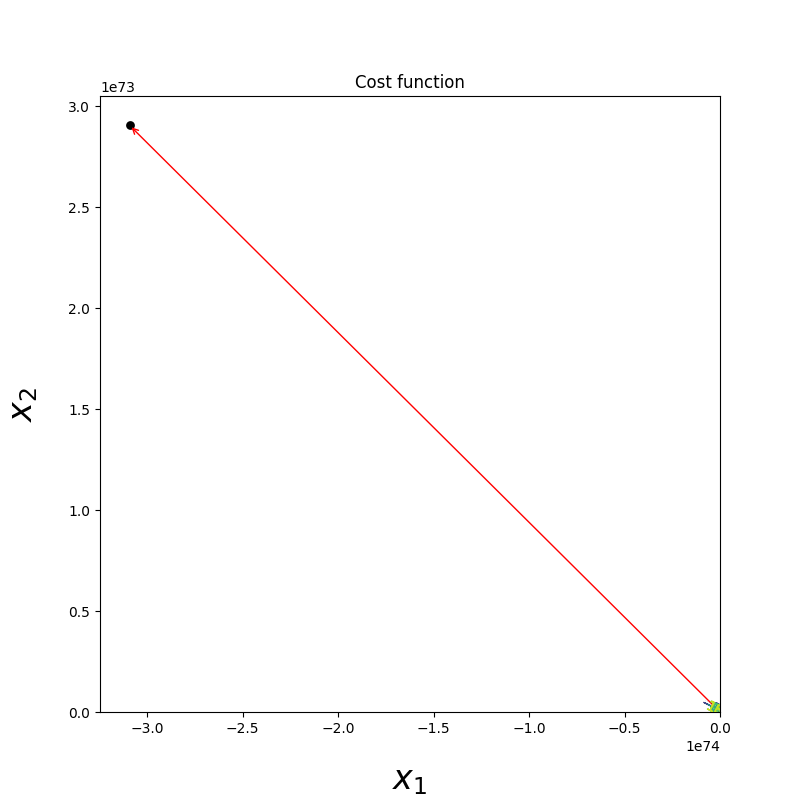

In [65]:
all_x = np.array(points)
all_x = np.reshape(all_x, ( int(all_x.size/2), 2 ))

all_f = np.array(values)
all_f = np.reshape(all_f, (all_f.size))

plot_2d_contour(all_x, f_obj, plot_h=True, plot_g=True, f_constraints=nlconstraints)
plot_3d_surface(all_x, all_f, f_obj, plot_h=True, plot_g=True, f_constraints=nlconstraints)